# Import

In [1]:
import sys
print(sys.executable)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib.patches as patches

# Run

Pig length (in pixels): 146


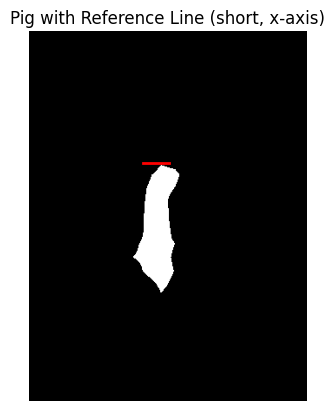

Pig length: 146.00 pixels ≈ 243.33 cm (using reference line)


In [7]:

model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()


input_image = Image.open('blackpig1.jpg')
preprocess = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)['out'][0]
mask = output.argmax(0).byte().cpu().numpy()

binary_mask = (mask != 0).astype(np.uint8)

labeled, num_features = ndimage.label(binary_mask)

sizes = ndimage.sum(binary_mask, labeled, range(1, num_features + 1))
largest_label = (sizes.argmax() + 1)
pig_mask = (labeled == largest_label)

coords = np.column_stack(np.where(pig_mask))

min_row, min_col = coords.min(axis=0)
max_row, max_col = coords.max(axis=0)

pig_length_pixels = max(max_row - min_row, max_col - min_col)
print("Pig length (in pixels):", pig_length_pixels)

fig, ax = plt.subplots()
ax.imshow(pig_mask, cmap='gray')
#rect = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
#linewidth=2, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

center_row = (min_row + max_row) // 3
ref_length = 30
ref_start_col = min_col + (max_col - min_col - ref_length) // 2
ref_end_col = ref_start_col + ref_length
ax.plot([ref_start_col, ref_end_col], [center_row, center_row], color='red', linewidth=2, label=f'Reference Line ({ref_length} px)')

plt.title("Pig with Reference Line (short, x-axis)")
plt.axis('off')
plt.show()

reference_length_cm = 50
pixels_per_cm = ref_length / reference_length_cm
pig_length_pixels = max(max_row - min_row, max_col - min_col)
pig_length_cm = pig_length_pixels / pixels_per_cm
print(f"Pig length: {pig_length_pixels:.2f} pixels ≈ {pig_length_cm:.2f} cm (using reference line)")

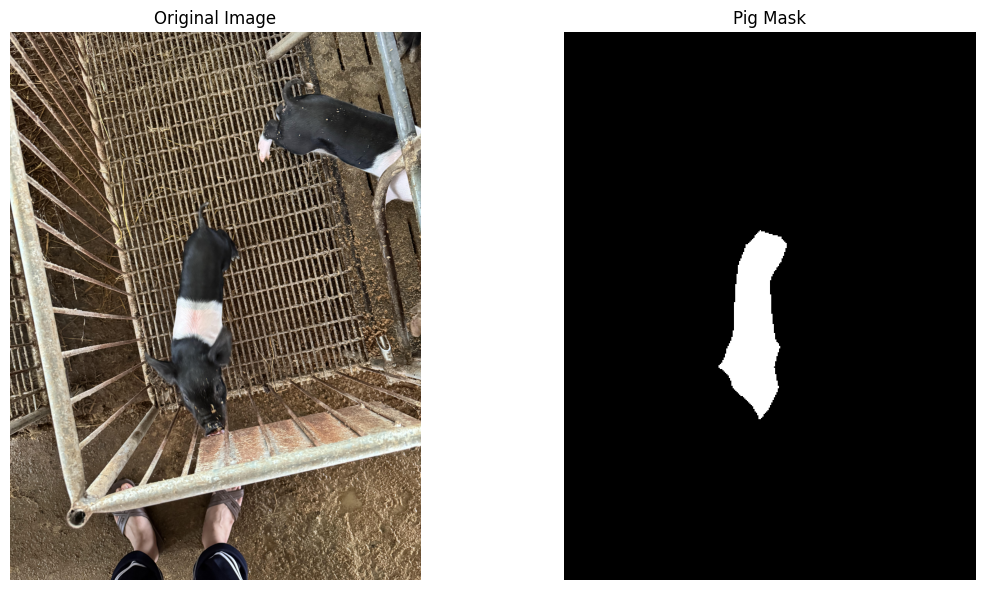

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(pig_mask, cmap='gray')
axes[1].set_title('Pig Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [14]:
import os
import glob

def load_image_mask_pairs(image_dir, mask_dir):
    """Loads image and mask file paths from specified directories."""
    image_paths = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    mask_paths = glob.glob(os.path.join(mask_dir, '*.png'))

    image_paths.sort()
    mask_paths.sort()

    if len(image_paths) != len(mask_paths):
        raise ValueError("Number of images and masks do not match!")

    return list(zip(image_paths, mask_paths))

image_directory = 'supervisely/augmented_dataset/img'
mask_directory = 'supervisely/augmented_dataset/masks'

try:
    dataset_pairs = load_image_mask_pairs(image_directory, mask_directory)
    print(f"Found {len(dataset_pairs)} image-mask pairs.")
    # You can inspect the first few pairs
    # print(dataset_pairs[:5])
except ValueError as e:
    print(f"Error loading dataset: {e}")

Found 1085 image-mask pairs.


In [15]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
# For binary segmentation (pig body vs. background), Binary Cross-Entropy is suitable
criterion = nn.BCEWithLogitsLoss() # Combines Sigmoid and BCELoss

# Define the optimizer
# Adam is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# You can also define other training parameters like learning rate scheduler, number of epochs, etc.
# For example, a learning rate scheduler can reduce the learning rate during training
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Training setup complete: Loss function and optimizer defined.")

Training setup complete: Loss function and optimizer defined.


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class PigSegmentationDataset(Dataset):
    def __init__(self, image_mask_pairs, image_transform=None, mask_transform=None):
        self.image_mask_pairs = image_mask_pairs
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB") # Ensure image is RGB
        mask = Image.open(mask_path).convert("L") # Convert mask to grayscale

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # Resize masks using nearest neighbor interpolation
    transforms.ToTensor(),
])

# Create the dataset
segmentation_dataset = PigSegmentationDataset(dataset_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create a DataLoader (you can adjust batch_size and shuffle)
dataloader = DataLoader(segmentation_dataset, batch_size=4, shuffle=True)

print(f"Created dataset with {len(segmentation_dataset)} samples.")
# You can iterate through the dataloader to get batches of data
# for images, masks in dataloader:
#     print(images.shape, masks.shape)
#     break

Created dataset with 1085 samples.


In [17]:
import torch
from torchvision import models

# Load the pre-trained DeepLabV3 model with a ResNet101 backbone
# Using weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1 for pretrained weights
model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)

# Replace the classifier to output 1 class (pig body)
# The original model outputs 21 classes (VOC dataset)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Modify the auxiliary classifier if present
# It has a different number of input channels than the main classifier
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


print("DeepLabV3 model customized for 1 output class.")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:28<00:00, 8.56MB/s] 


DeepLabV3 model customized for 1 output class.


In [18]:
!pip install --upgrade torchmetrics

   ---------------------------------------- 0.0/983.2 kB ? eta -:--:--
   ---------------------------------------- 983.2/983.2 kB 6.0 MB/s  0:00:00

   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- ------------------- 1/2 [torchmetrics]
   -------------------- --------

In [19]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (e.g., 80% train, 20% test)
train_pairs, test_pairs = train_test_split(dataset_pairs, test_size=0.2, random_state=42)

# Split the testing set into validation and testing sets (e.g., 50% validation, 50% test)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

print(f"Number of training samples: {len(train_pairs)}")
print(f"Number of validation samples: {len(val_pairs)}")
print(f"Number of testing samples: {len(test_pairs)}")

Number of training samples: 868
Number of validation samples: 108
Number of testing samples: 109


In [20]:
# Create the dataset instances
train_dataset = PigSegmentationDataset(train_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
val_dataset = PigSegmentationDataset(val_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
test_dataset = PigSegmentationDataset(test_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create the DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Created training dataset with {len(train_dataset)} samples and dataloader.")
print(f"Created validation dataset with {len(val_dataset)} samples and dataloader.")
print(f"Created testing dataset with {len(test_dataset)} samples and dataloader.")

Created training dataset with 868 samples and dataloader.
Created validation dataset with 108 samples and dataloader.
Created testing dataset with 109 samples and dataloader.


In [24]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")
else:
    print("WARNING: CUDA not available, using CPU only!")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
GPU device: NVIDIA GeForce RTX 5070 Ti
GPU count: 1


In [26]:
from torchmetrics.classification import BinaryJaccardIndex

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
iou_metric = BinaryJaccardIndex().to(device)

print("IoU metric initialized.")

IoU metric initialized.


In [27]:
def train_fn(num_epochs, model, train_dataloader, criterion, optimizer_class, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr)

    print(f"Starting training on device: {device} with lr={lr} and optimizer={optimizer_class.__name__}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_dataloader: # Use train_dataloader
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)['out']
            loss = criterion(outputs, masks.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print("Training finished!")

# Grid search loop
import itertools

# Define hyperparameter grid (adjust values as needed)
keys = ['num_epochs', 'optimizer', 'lr']
values = [
    [5, 10],  # num_epochs options
    [torch.optim.Adam, torch.optim.SGD],  # optimizer classes
    [1e-3, 1e-4]  # learning rates
]

print(f"Hyperparameter grid keys: {keys}")
print(f"Number of combinations: {len(list(itertools.product(*values)))}")

best_iou = -1
best_dice = -1
best_hyperparameters = None

for combination in itertools.product(*values):
    hyperparameters = dict(zip(keys, combination))
    print(f"Training with hyperparameters: {hyperparameters}")

    # Re-initialize the model for each training run
    model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    if model.aux_classifier is not None:
        model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


    # Train the model with the current hyperparameters using the train_dataloader
    train_fn(
        num_epochs=hyperparameters['num_epochs'],
        model=model,
        train_dataloader=train_dataloader, # Pass train_dataloader
        criterion=criterion,
        optimizer_class=hyperparameters['optimizer'],
        lr=hyperparameters['lr']
    )

    # Evaluate the model on the validation set using the val_dataloader
    model.eval()
    iou_metric.reset()
    total_dice = 0.0
    num_batches = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    iou_metric.to(device)


    with torch.no_grad():
        for images, masks in val_dataloader: # Use val_dataloader for evaluation
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            probabilities = torch.sigmoid(outputs)
            predicted_masks = (probabilities > 0.5).squeeze(1)

            masks = masks.squeeze(1).bool()

            batch_iou = iou_metric(predicted_masks.int(), masks.int())

            intersection = (predicted_masks & masks).sum()
            union = (predicted_masks | masks).sum()
            batch_dice = (2. * intersection) / (union + intersection) if (union + intersection) > 0 else 1.0

            total_dice += batch_dice.item()
            num_batches += 1

    # Protect against division by zero if no batches were evaluated
    average_iou = iou_metric.compute().item() if num_batches > 0 else 0.0
    average_dice = total_dice / num_batches if num_batches > 0 else 0.0

    print(f"Evaluation results - IoU: {average_iou:.4f}, Dice: {average_dice:.4f}")

    if average_iou > best_iou:
        best_iou = average_iou
        best_dice = average_dice
        best_hyperparameters = hyperparameters

print("\nGrid search finished.")
print("Best Hyperparameters:", best_hyperparameters)
print(f"Best IoU: {best_iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")


Hyperparameter grid keys: ['num_epochs', 'optimizer', 'lr']
Number of combinations: 8
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/5], Loss: 0.0706
Epoch [2/5], Loss: 0.0171
Epoch [3/5], Loss: 0.0111
Epoch [4/5], Loss: 0.0093
Epoch [5/5], Loss: 0.0082
Training finished!
Evaluation results - IoU: 0.9065, Dice: 0.9533
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0001}
Starting training on device: cuda with lr=0.0001 and optimizer=Adam
Epoch [1/5], Loss: 0.3320
Epoch [2/5], Loss: 0.1414
Epoch [3/5], Loss: 0.0754
Epoch [4/5], Loss: 0.0478
Epoch [5/5], Loss: 0.0333
Training finished!
Evaluation results - IoU: 0.8707, Dice: 0.9317
Training with hyperparameters: {'num_epochs': 5, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=SG

In [ ]:
# Get the best parameter and train again to save model

print("\nGrid search finished.")
print("Best Hyperparameters:", best_hyperparameters)
print(f"Best IoU: {best_iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")

# Save the best model
if best_hyperparameters is not None:
    print("\n" + "="*60)
    print("Retraining and saving the best model...")
    print(f"Best hyperparameters: {best_hyperparameters}")
    print("="*60)
    
    # Re-initialize the model with the best architecture
    best_model = models.segmentation.deeplabv3_resnet101(
        weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
    )
    best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    if best_model.aux_classifier is not None:
        best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    
    # Retrain with best hyperparameters
    train_fn(
        num_epochs=best_hyperparameters['num_epochs'],
        model=best_model,
        train_dataloader=train_dataloader,
        criterion=criterion,
        optimizer_class=best_hyperparameters['optimizer'],
        lr=best_hyperparameters['lr']
    )
    
    # Create directory for saved models
    save_dir = 'saved_models'
    os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, 'best_pig_segmentation_model.pth')
    checkpoint_path = os.path.join(save_dir, 'best_pig_segmentation_checkpoint.pth')
    
    # Save model state dict
    torch.save(best_model.state_dict(), model_path)
    print(f"\n✓ Best model saved to: {model_path}")
    
    # Save complete checkpoint with hyperparameters and metrics
    checkpoint = {
        'model_state_dict': best_model.state_dict(),
        'hyperparameters': best_hyperparameters,
        'best_iou': best_iou,
        'best_dice': best_dice,
        'epoch': best_hyperparameters['num_epochs']
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Complete checkpoint saved to: {checkpoint_path}")
    
    print("\n" + "="*60)
    print("MODEL SAVED SUCCESSFULLY!")
    print(f"Location: {os.path.abspath(save_dir)}")
    print("="*60)
    
    print("\nTo load this model later, use:")
    print("""
# Load the model architecture
model = models.segmentation.deeplabv3_resnet101(weights=None)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model.load_state_dict(torch.load('saved_models/best_pig_segmentation_model.pth'))
model.eval()

# Or load the complete checkpoint
checkpoint = torch.load('saved_models/best_pig_segmentation_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model with IoU: {checkpoint['best_iou']:.4f}")
    """)
else:
    print("\nNo best hyperparameters found. Training may have failed.")


Grid search finished.
Best Hyperparameters: {'num_epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Best IoU: 0.9117
Best Dice Score: 0.9549

Retraining and saving the best model...
Best hyperparameters: {'num_epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/10], Loss: 0.0656
Epoch [2/10], Loss: 0.0174
Epoch [3/10], Loss: 0.0145
Epoch [4/10], Loss: 0.0113
Epoch [5/10], Loss: 0.0095
Epoch [6/10], Loss: 0.0082
Epoch [7/10], Loss: 0.0074
Epoch [8/10], Loss: 0.0076
Epoch [9/10], Loss: 0.0117
Epoch [10/10], Loss: 0.0133
Training finished!

✓ Best model saved to: saved_models\best_pig_segmentation_model.pth
✓ Complete checkpoint saved to: saved_models\best_pig_segmentation_checkpoint.pth

MODEL SAVED SUCCESSFULLY!
Location: d:\Wave_CMKL\Year2_term1\URD-2_BlackPigProject\pig_segmentation\segment\saved_models

To load this model later, use:

# Load the model architecture
mo

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth


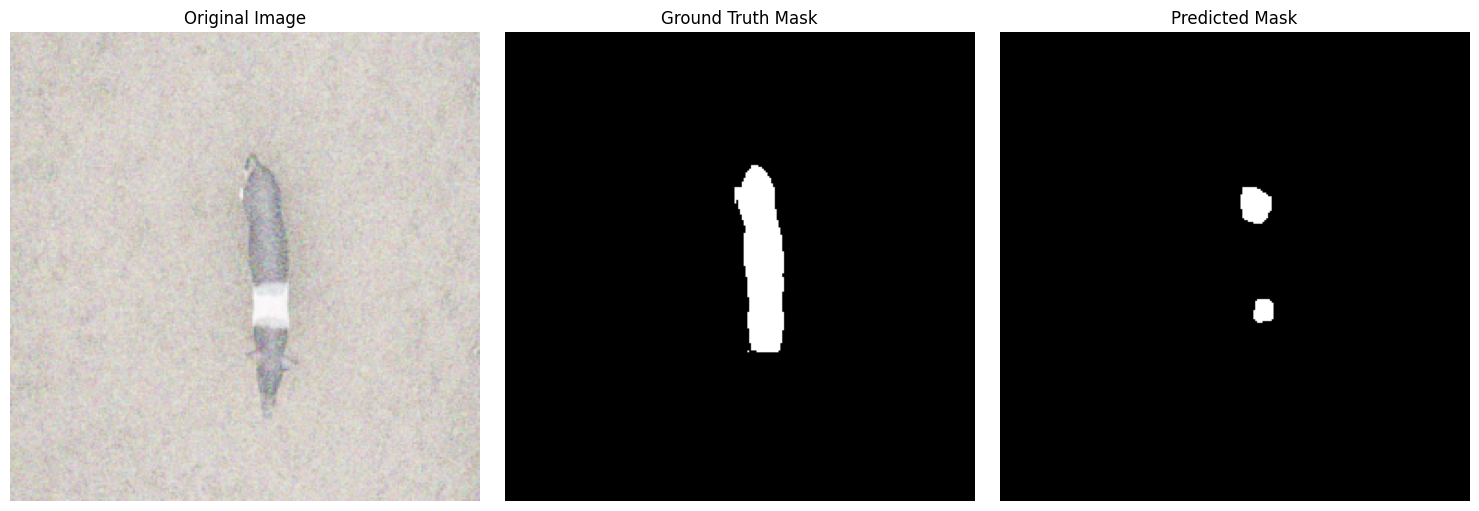

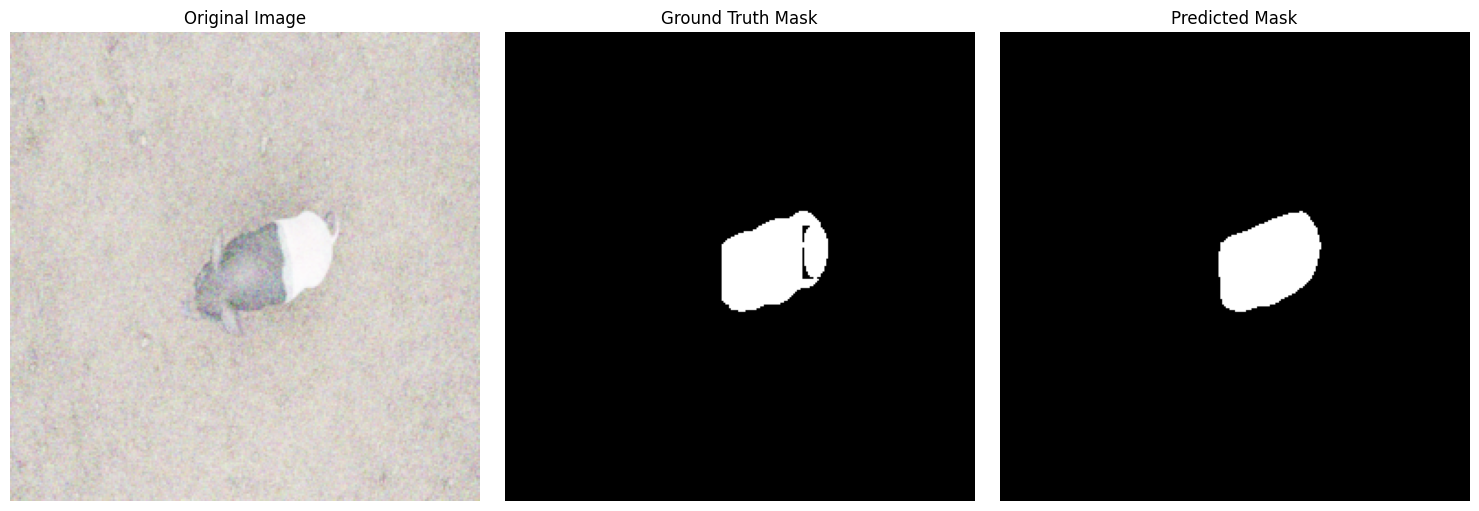

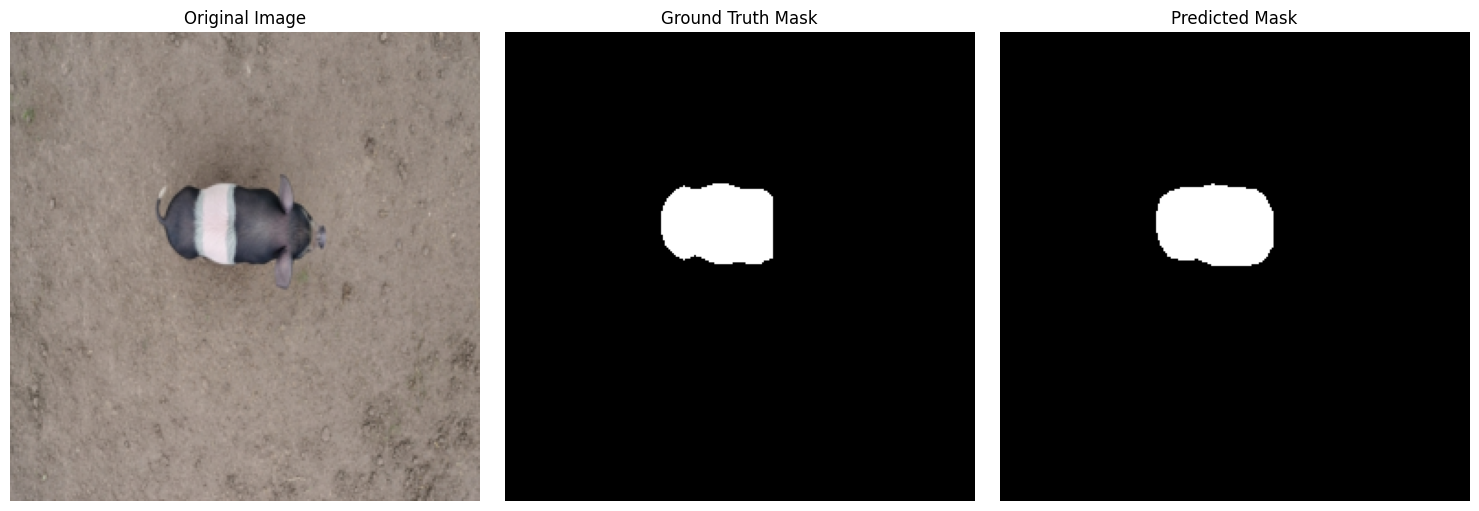

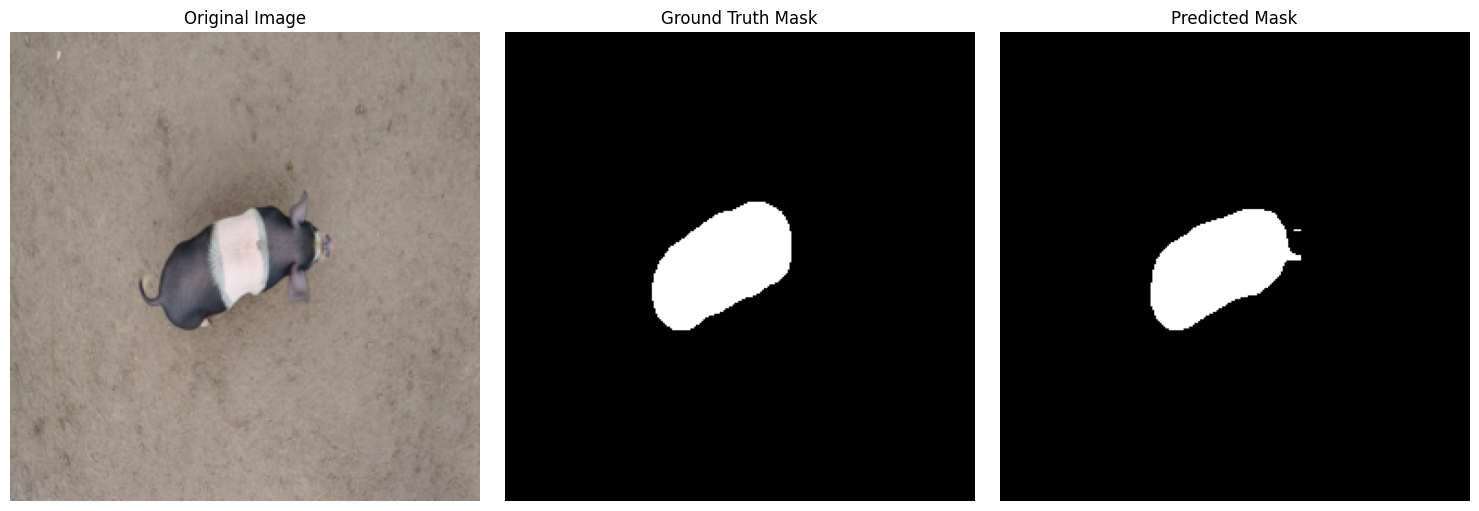

In [ ]:
# test the model with samples

import matplotlib.pyplot as plt

# Load the best trained model
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# Get a batch of images and masks from the dataloader
images, masks = next(iter(dataloader))

# Move tensors to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

images = images.to(device)
masks = masks.to(device)

# Get model predictions
with torch.no_grad():
    outputs = best_model(images)['out']

# Apply sigmoid and threshold to get binary masks
probabilities = torch.sigmoid(outputs)
predicted_masks = (probabilities > 0.5).squeeze(1).cpu().numpy()

# Move original images and ground truth masks back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().squeeze(1).numpy()

# Denormalize images for better visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)

# Visualize the results
for i in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(masks[i], cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_masks[i], cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth
Showing 4 random test images...


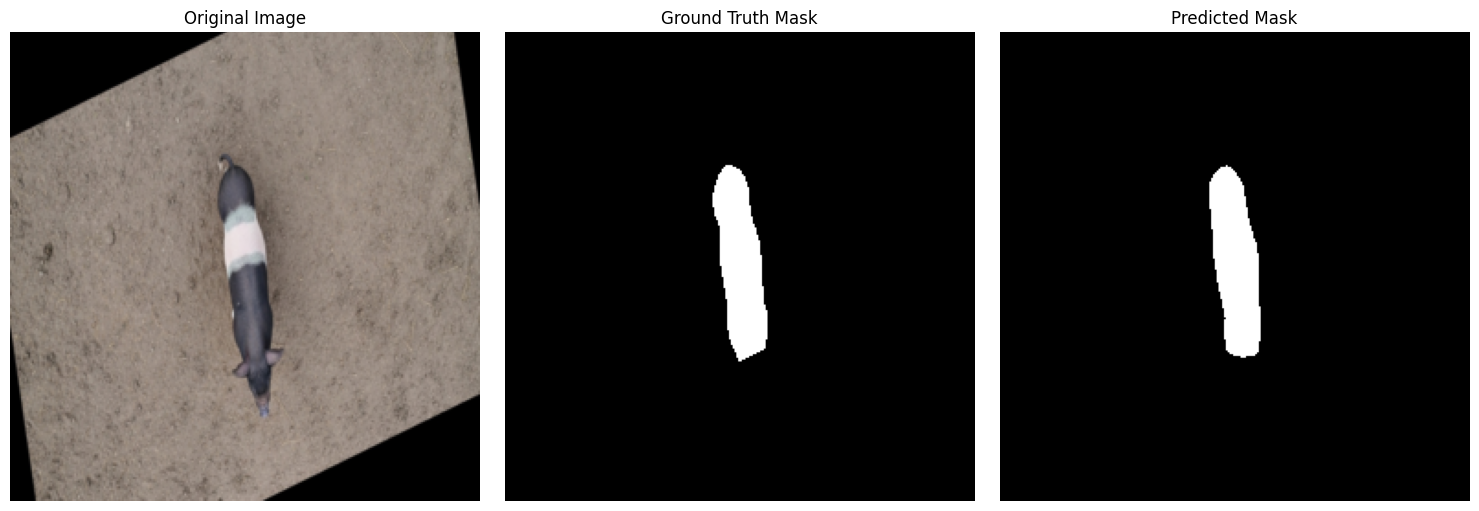

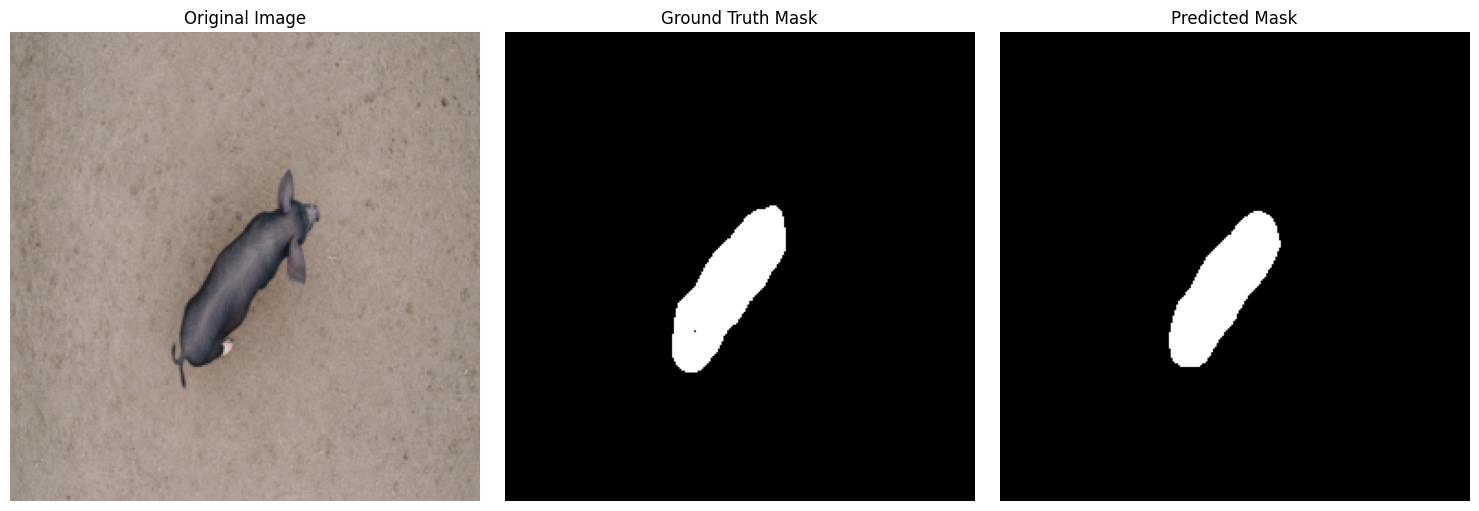

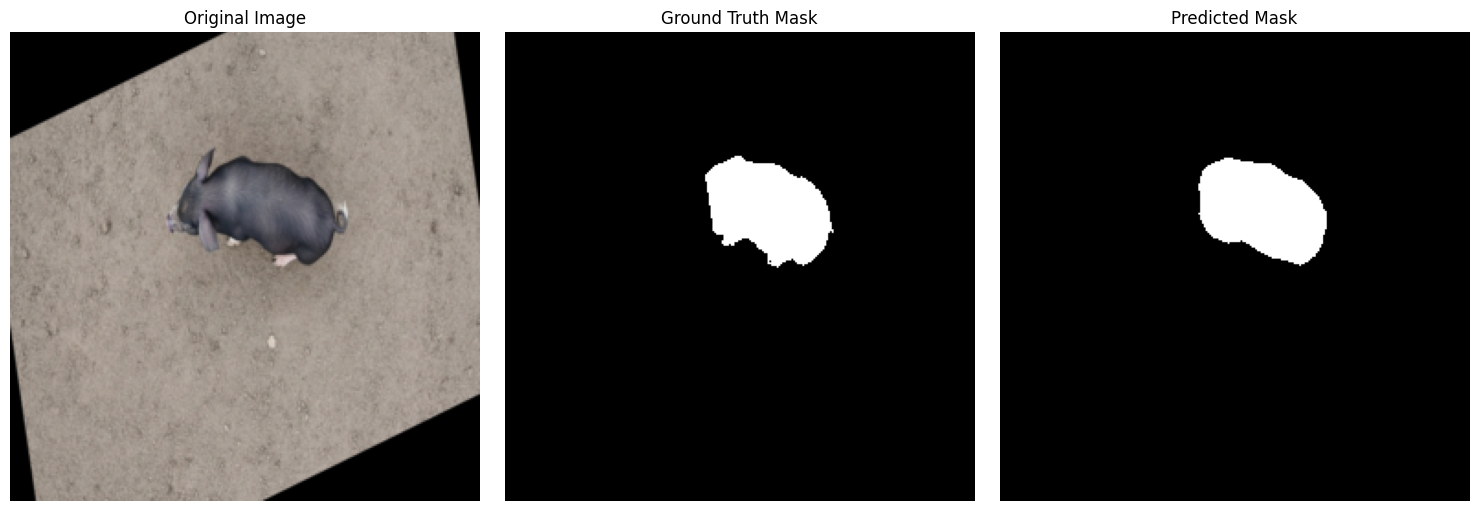

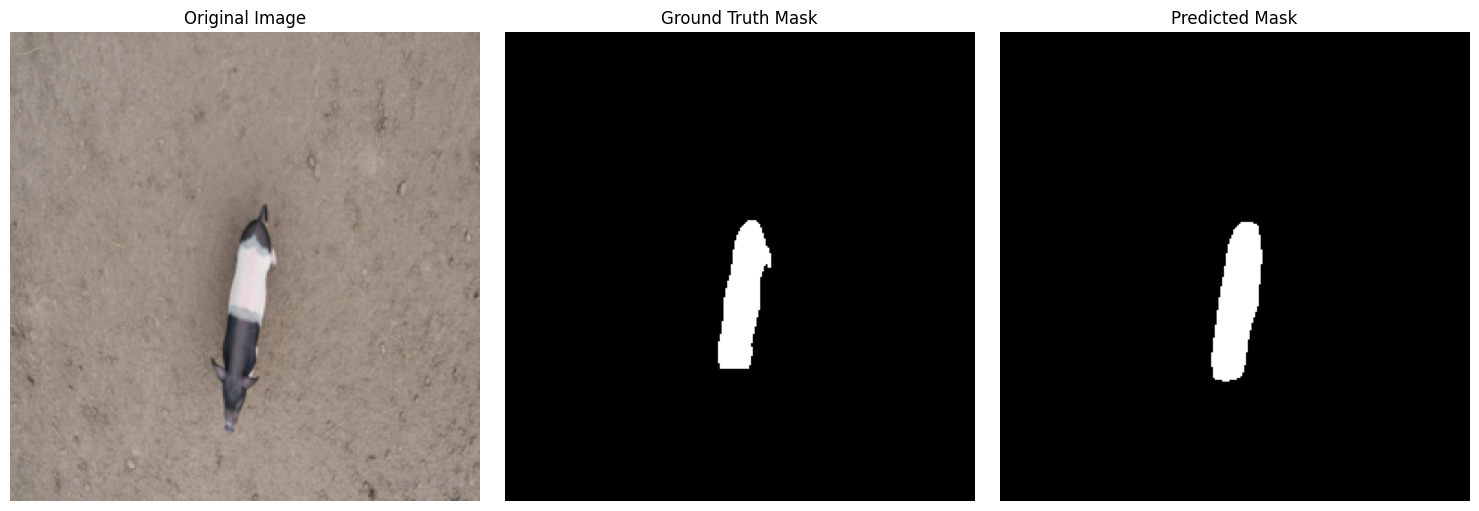

In [ ]:
# random 5 images from test set to test the model

import matplotlib.pyplot as plt
import random

# Load the best trained model
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# Create a new dataloader with shuffle=True to get random samples each time
test_dataloader_random = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Get a random batch of images and masks from the TEST dataloader
images, masks = next(iter(test_dataloader_random))

# Move tensors to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

images = images.to(device)
masks = masks.to(device)

# Get model predictions
with torch.no_grad():
    outputs = best_model(images)['out']

# Apply sigmoid and threshold to get binary masks
probabilities = torch.sigmoid(outputs)
predicted_masks = (probabilities > 0.5).squeeze(1).cpu().numpy()

# Move original images and ground truth masks back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().squeeze(1).numpy()

# Denormalize images for better visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std + mean
images = np.clip(images, 0, 1)

# Visualize the results
print(f"Showing {images.shape[0]} random test images...")
for i in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(masks[i], cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_masks[i], cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Loading the best saved model...
Model loaded from saved_models/best_pig_segmentation_model.pth


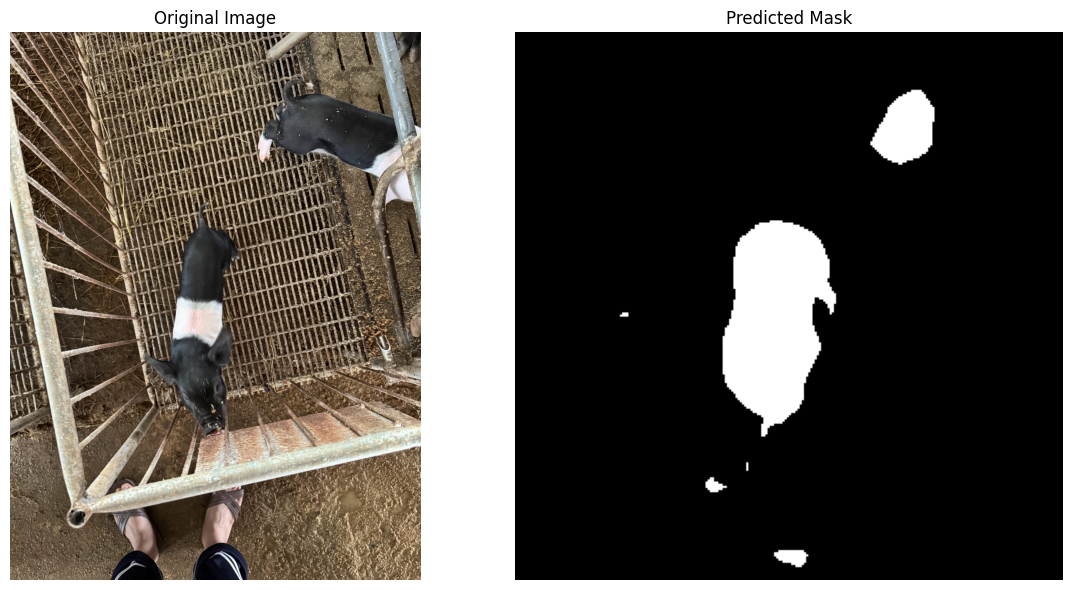

In [32]:
# Load the best trained model
print("Loading the best saved model...")
best_model = models.segmentation.deeplabv3_resnet101(
    weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
)
best_model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
if best_model.aux_classifier is not None:
    best_model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Load the saved weights
model_path = 'saved_models/best_pig_segmentation_model.pth'
best_model.load_state_dict(torch.load(model_path))
print(f"Model loaded from {model_path}")

# Define the path to your input image
input_image_path = 'blackpig1.jpg'  # Update this path as needed

# Load the input image
input_image = Image.open(input_image_path).convert("RGB")

# Apply the same transformations as used for the training data
input_tensor = image_transforms(input_image).unsqueeze(0)  # Add a batch dimension

# Move the model and input tensor to the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode and disable gradient calculation
with torch.no_grad():
    # Get model prediction
    output = best_model(input_tensor)['out']

# Apply sigmoid and threshold to get a binary mask
probabilities = torch.sigmoid(output)
predicted_mask = (probabilities > 0.5).squeeze(0).squeeze(0).cpu().numpy()  # Remove batch and channel dimensions

# Visualize the original image and the predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(input_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted Mask
axes[1].imshow(predicted_mask, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()